In [1]:
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# !nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
# !lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
# !free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=28)
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)

import math
import time 
# from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
print(is_gpu)

False


# CFD Parameters

In [5]:
dt = 0.5
dx = 1.0
dy = 1.0
dz = 1.0
Re = 1/20
ub = 1
# nx = 4096
# ny = 4096
# nz = 256
nx = 128
ny = 128
nz = 128
ratio = int(nx/nz)
nlevel = int(math.log(nz, 2)) + 1 
print('Levels of Multigrid:', nlevel)
print('Aspect ratio of Domain:', ratio)

Levels of Multigrid: 8
Aspect ratio of Domain: 1


# Weights of CNNs layers

In [6]:
pd1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pd2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pd3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w1 = np.zeros([1,3,3,3,1])
w1[0,0,:,:,0] = np.array(pd1)*dt*Re/dx**2
w1[0,1,:,:,0] = np.array(pd2)*dt*Re/dx**2 
w1[0,2,:,:,0] = np.array(pd3)*dt*Re/dx**2 

In [7]:
p_div_x1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])

w2[0,0,:,:,0] = np.array(p_div_x1)*dt/dx*0.5
w2[0,1,:,:,0] = np.array(p_div_x2)*dt/dx*0.5
w2[0,2,:,:,0] = np.array(p_div_x3)*dt/dx*0.5

w3[0,0,:,:,0] = np.array(p_div_y1)*dt/dx*0.5
w3[0,1,:,:,0] = np.array(p_div_y2)*dt/dx*0.5
w3[0,2,:,:,0] = np.array(p_div_y3)*dt/dx*0.5 

w4[0,0,:,:,0] = np.array(p_div_z1)*dt/dx*0.5 
w4[0,1,:,:,0] = np.array(p_div_z2)*dt/dx*0.5
w4[0,2,:,:,0] = np.array(p_div_z3)*dt/dx*0.5

In [8]:
pA1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pA2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pA3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w5 = np.zeros([1,3,3,3,1])
w5[0,0,:,:,0] = -np.array(pA1)/dx**2
w5[0,1,:,:,0] = -np.array(pA2)/dx**2 
w5[0,2,:,:,0] = -np.array(pA3)/dx**2 

In [9]:
pctyu1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
pctyu2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
pctyu3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

pctyv1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
pctyv2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
pctyv3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

pctyw1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
pctyw2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
pctyw3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w6 = np.zeros([1,3,3,3,1])
w7 = np.zeros([1,3,3,3,1])
w8 = np.zeros([1,3,3,3,1])
w9 = np.zeros([1,2,2,2,1])
w6[0,0,:,:,0] = np.array(pctyu1)/(dx*dt)*0.5
w6[0,1,:,:,0] = np.array(pctyu2)/(dx*dt)*0.5
w6[0,2,:,:,0] = np.array(pctyu3)/(dx*dt)*0.5
w7[0,0,:,:,0] = np.array(pctyv1)/(dx*dt)*0.5
w7[0,1,:,:,0] = np.array(pctyv2)/(dx*dt)*0.5
w7[0,2,:,:,0] = np.array(pctyv3)/(dx*dt)*0.5 
w8[0,0,:,:,0] = np.array(pctyw1)/(dx*dt)*0.5
w8[0,1,:,:,0] = np.array(pctyw2)/(dx*dt)*0.5
w8[0,2,:,:,0] = np.array(pctyw3)/(dx*dt)*0.5
w9[0,:,:,:,0] = 0.125

In [10]:
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation

In [11]:
CNN3D_central_2nd_dif = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_zadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_6,
                                bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_7,
                                bias_initializer=bias_initializer),
])

CNN3D_Sw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_8,
                                bias_initializer=bias_initializer),
])


# Libraries for multigrid algorithms

In [12]:
for i in range(nlevel):
    locals()['CNN3D_A_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-1-i)), int(ny*0.5**(nlevel-1-i)), int(nx*0.5**(nlevel-1-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer)
    ])

In [13]:
for i in range(nlevel-1):
    locals()['CNN3D_res_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-2-i)), int(ny*0.5**(nlevel-2-i)), int(nx*0.5**(nlevel-2-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),   
    ])    

In [14]:
for i in range(nlevel-1):
    locals()['CNN3D_prol_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*2**i, 1*ratio*2**i, 1*ratio*2**i, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
    ])

# Functions linking to the AI libraries

In [15]:
def boundary_condition_velocity(values_u,values_v,values_w):
    'Define boundary conditions for velocity field'
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempw = tf.Variable(values_w) 
    tempu[0,:,:,0,0].assign(tf.Variable(tf.ones((1,nz,ny)))[0,:]*ub) 
    tempv[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])    
    tempw[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])    

    tempu[0,:,:,nx-1,0].assign(tf.Variable(tf.ones((1,nz,ny)))[0,:]*ub) 
    tempv[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])   
    tempw[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])  
    
    tempu[0,:,0,:,0].assign(tf.Variable(values_u)[0,:,1,:,0])     
    tempv[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])  
    tempw[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])  
        
    tempu[0,:,nx-1,:,0].assign(tf.Variable(values_u)[0,:,nx-2,:,0])      
    tempv[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])     
    tempw[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])  
    
    tempu[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])     
    tempv[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])  
    tempw[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])  
        
    tempu[0,nz-1,:,:,0].assign(tf.Variable(values_u)[0,nz-2,:,:,0])      
    tempv[0,nz-1,:,:,0].assign(tf.Variable(values_v)[0,nz-2,:,:,0])     
    tempw[0,nz-1,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])      
    return tempu,tempv,tempw

def boundary_condition_pressure(values_p,nx):
    'Define boundary conditions for pressure field'
    tempp = tf.Variable(values_p)   
    tempp[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:]) 
    tempp[0,:,:,0,0].assign(tf.Variable(values_p)[0,:,:,1,0])
    
    tempp[0,:,0,:,0].assign(tf.Variable(values_p)[0,:,1,:,0])     
    tempp[0,:,nx-1,:,0].assign(tf.Variable(values_p)[0,:,nx-2,:,0]) 
    
    tempp[0,0,:,:,0].assign(tf.Variable(values_p)[0,1,:,:,0])     
    tempp[0,nz-1,:,:,0].assign(tf.Variable(values_p)[0,nz-2,:,:,0])  
    return tempp

def boundary_condition_indicator(alpha,nx):   
    'Define boundary conditions for scalar field'
    tempa = tf.Variable(alpha)   
    tempa[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempa[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])
    
    tempa[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    
    tempa[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    return tempa

def boundary_condition_source(b,nx):  
    'Define inflow boundary conditions for source terms to'
    'avoid incorrect paddings caused by CNNs'
    tempb = tf.Variable(b)   
    tempb[0,:,:,0,0].assign(tf.Variable(b)[0,:,:,1,0])
    return tempb

def bluff_body(values_u,values_v,values_w,sigma):
    'Immersed Boundary for buildings'
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma)
    temp3 = values_w / (1+dt*sigma) 
    return temp1,temp2,temp3

def save_data(n_out,itime):
    'Save field data'
    if itime % n_out == 0:  
        np.save("data_SK_Petrov_Galerkin_demo/uu"+str(itime), arr=values_u[0,:,:,:,0])
        np.save("data_SK_Petrov_Galerkin_demo/vv"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("data_SK_Petrov_Galerkin_demo/ww"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("data_SK_Petrov_Galerkin_demo/pp"+str(itime), arr=values_p[0,:,:,:,0])

In [16]:
def Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''
    values_u = values_u / (1+dt*sigma) 
    values_v = values_v / (1+dt*sigma)     
    values_w = values_w / (1+dt*sigma) 
      
    k_u = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               CNN3D_central_2nd_dif(values_u)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_u)) + 
                               abs(CNN3D_central_2nd_yadv(values_u)) + 
                               abs(CNN3D_central_2nd_zadv(values_u)))/3)
    
    k_v = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               CNN3D_central_2nd_dif(values_v)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_v)) + 
                               abs(CNN3D_central_2nd_yadv(values_v)) + 
                               abs(CNN3D_central_2nd_zadv(values_v)))/3)
    
    k_w = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               CNN3D_central_2nd_dif(values_w)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_w)) + 
                               abs(CNN3D_central_2nd_yadv(values_w)) + 
                               abs(CNN3D_central_2nd_zadv(values_w)))/3)
       
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)*0.5) / (1+dt*sigma) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)*0.5) / (1+dt*sigma)     
    k_w = tf.math.minimum(k_w, tf.ones(input_shape)*0.5) / (1+dt*sigma)    
    
    
    k_x = 3*0.5*(k_u*CNN3D_central_2nd_dif(values_u) +
                CNN3D_central_2nd_dif(values_u*k_u) -
                values_u*CNN3D_central_2nd_dif(k_u))


    k_y = 3*0.5*(k_v*CNN3D_central_2nd_dif(values_v) + 
                CNN3D_central_2nd_dif(values_v*k_v) -
                values_v*CNN3D_central_2nd_dif(k_v))


    k_z = 3*0.5*(k_w*CNN3D_central_2nd_dif(values_w) + 
                CNN3D_central_2nd_dif(values_w*k_w) -
                values_w*CNN3D_central_2nd_dif(k_w))

    return k_x, k_y, k_z

# Initialise

============== Numerical parameters ===============
Mesh resolution: (1, 128, 128, 128, 1)
Time step: 8000
Initial time: 0
Switch on IBM solver!


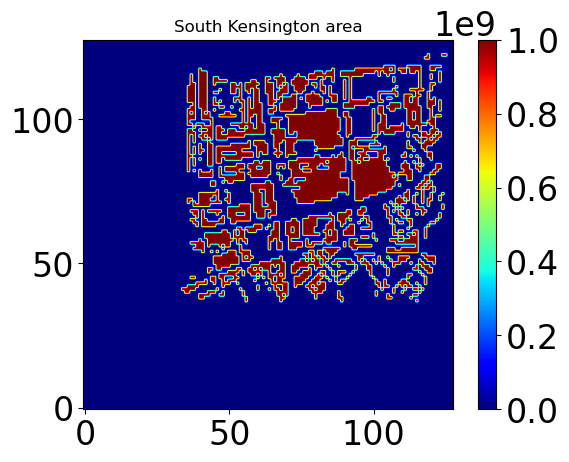

In [19]:
#################### Create field #####£###############
input_shape = (1,nz,ny,nx,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)
#######################################################
################# Numerical parameters ################
multi_itr = 5               # Iterations of multi-grid 
j_itr = 1                   # Iterations of Jacobi 
ntime = 10                 # Time steps (fewer timesteps)
n_out = 500                 # Results output
nrestart = 0                # Last time step for restart
ctime_old = 0               # Last ctime for restart
mgsolver = True             # Multigrid solver
LSCALAR = False              # Scalar transport 
LMTI = False                 # Non density for multiphase flows
LIBM = True                # Immersed boundary method 
nsafe = 0.5                 # Continuty equation residuals
ctime = 0                   # Initialise ctime   
save_fig = True             # Save results
Restart = False             # Restart
eplsion_k = 1e-03
################# Physical parameters #################
rho_l = 1000                # Density of liquid phase 
rho_g = 980                 # Density of gas phase 
g_x = 0;g_y = 0;g_z = -9.8   # Gravity acceleration (m/s2) 
#######################################################
print('============== Numerical parameters ===============')
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
#######################################################
# Eliminated codes that are not relevant
################# Only for IBM ########################
if LIBM == True:
    # mesh = np.load('INHALE_1280.npy')
    mesh = np.load('master/mesh_64_sk.npy')
    sigma = np.zeros(input_shape).astype('float32')
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            for k in range(1,nz-1):
                if mesh[0][i][j][k][0] == 0:
                    sigma[0][k][j][i][0] = 1000000000  
    sigma = tf.convert_to_tensor(sigma)
    print('Switch on IBM solver!')
    print('===================================================')
    plt.imshow(sigma[0,1,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('South Kensington area')
    plt.gca().invert_yaxis()
#######################################################

# AI-HFM Solver

In [20]:
start = time.time()
for itime in range(1,ntime+1): 
    ctime = ctime + dt 
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
    values_p = boundary_condition_pressure(values_p,nx)
    # Petrov-Galerkin dissipation
    [k_x,k_y,k_z] = Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma)
    # Momentum equation 
    a_u = k_x - \
    values_u*CNN3D_central_2nd_xadv(values_u) - \
    values_v*CNN3D_central_2nd_yadv(values_u) - \
    values_w*CNN3D_central_2nd_zadv(values_u)
    b_u = 0.5*a_u + values_u
    a_v = k_y - \
    values_u*CNN3D_central_2nd_xadv(values_v) - \
    values_v*CNN3D_central_2nd_yadv(values_v) - \
    values_w*CNN3D_central_2nd_zadv(values_v)
    b_v = 0.5*a_v + values_v
    a_w = k_z - \
    values_u*CNN3D_central_2nd_xadv(values_w) - \
    values_v*CNN3D_central_2nd_yadv(values_w) - \
    values_w*CNN3D_central_2nd_zadv(values_w) 
    b_w = 0.5*a_w + values_w

    [b_u,b_v,b_w] = boundary_condition_velocity(b_u,b_v,b_w)
    [kb_x,kb_y,kb_z] = Petrov_Galerkin_dissipation(b_u, b_v, b_w, eplsion_k, sigma)

    c_u = kb_x - \
    b_u*CNN3D_central_2nd_xadv(b_u) - \
    b_v*CNN3D_central_2nd_yadv(b_u) - \
    b_w*CNN3D_central_2nd_zadv(b_u)
    values_u = values_u + c_u      
    c_v = kb_y - \
    b_u*CNN3D_central_2nd_xadv(b_v) - \
    b_v*CNN3D_central_2nd_yadv(b_v) - \
    b_w*CNN3D_central_2nd_zadv(b_v) 
    values_v = values_v + c_v
    c_w = kb_z - \
    b_u*CNN3D_central_2nd_xadv(b_w) - \
    b_v*CNN3D_central_2nd_yadv(b_w) - \
    b_w*CNN3D_central_2nd_zadv(b_w) 
    values_w = values_w + c_w    
    # Passive tracer scalar transport
    if LSCALAR == True:
        a_t = CNN3D_central_2nd_dif(alpha) - \
        values_u*CNN3D_central_2nd_xadv(alpha) - \
        values_v*CNN3D_central_2nd_yadv(alpha) - \
        values_w*CNN3D_central_2nd_zadv(alpha)
        alpha = alpha + a_t
        alpha = boundary_condition_indicator(alpha,nx)
    if LMTI == True:
        rho = alpha*rho_l + (1-alpha)*rho_g
    # IBM
    # if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
    # gradp            
    values_u = values_u - CNN3D_central_2nd_xadv(values_p)
    values_v = values_v - CNN3D_central_2nd_yadv(values_p)  
    values_w = values_w - CNN3D_central_2nd_zadv(values_p)     
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
    
    # possion equation (multi-grid) A*P = Su
    b = -(CNN3D_Su(values_u) + CNN3D_Sv(values_v) + CNN3D_Sw(values_w))
    b = boundary_condition_source(b,nx)
    
    # the multi-grid process
    if mgsolver == True:
        for multi_grid in range(multi_itr): 
            # compute the residual
            w_1 = tf.zeros([1,1,ratio,ratio,1])
            r = CNN3D_A_256(values_p) - b   
            r = tf.Variable(r)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:]) 
#             r_256 = CNN3D_res_512(r) 
            r_128 = CNN3D_res_256(r) 
            r_64 = CNN3D_res_128(r_128) 
            r_32 = CNN3D_res_64(r_64) 
            r_16 = CNN3D_res_32(r_32) 
            r_8 = CNN3D_res_16(r_16) 
            r_4 = CNN3D_res_8(r_8) 
            r_2 = CNN3D_res_4(r_4) 
            r_1 = CNN3D_res_2(r_2)
            
            for Jacobi in range(j_itr):
                w_1 = (w_1 - CNN3D_A_1(w_1)/w5[0,1,1,1,0] + r_1/w5[0,1,1,1,0])
            w_2 = CNN3D_prol_1(w_1)             
            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2)/w5[0,1,1,1,0] + r_2/w5[0,1,1,1,0])
            w_4 = CNN3D_prol_2(w_2) 
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4)/w5[0,1,1,1,0] + r_4/w5[0,1,1,1,0])
            w_8 = CNN3D_prol_4(w_4) 
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8)/w5[0,1,1,1,0] + r_8/w5[0,1,1,1,0])
            w_16 = CNN3D_prol_8(w_8) 
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16)/w5[0,1,1,1,0] + r_16/w5[0,1,1,1,0])
            w_32 = CNN3D_prol_16(w_16) 
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32)/w5[0,1,1,1,0] + r_32/w5[0,1,1,1,0])
            w_64 = CNN3D_prol_32(w_32) 
            for Jacobi in range(j_itr):
                w_64 = (w_64 - CNN3D_A_64(w_64)/w5[0,1,1,1,0] + r_64/w5[0,1,1,1,0])
            w_128 = CNN3D_prol_64(w_64) 
            for Jacobi in range(j_itr):
                w_128 = (w_128 - CNN3D_A_128(w_128)/w5[0,1,1,1,0] + r_128/w5[0,1,1,1,0] )
            w_256 = CNN3D_prol_128(w_128)
#             for Jacobi in range(j_itr):
#                 w_256 = (w_256 - CNN3D_A_256(w_256)/w5[0,1,1,1,0] + r_256/w5[0,1,1,1,0] )
#             w_512 = CNN3D_prol_256(w_256)
            values_p = values_p - w_256
            values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])         
            values_p = (values_p - CNN3D_A_256(values_p)/w5[0,1,1,1,0] + b/w5[0,1,1,1,0])          
# correct
    values_p = boundary_condition_pressure(values_p,nx)
    values_u = values_u - CNN3D_central_2nd_xadv(values_p)
    values_v = values_v - CNN3D_central_2nd_yadv(values_p)  
    values_w = values_w - CNN3D_central_2nd_zadv(values_p)      
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# output   
    print('Time step:', itime) 
    print('Pressure error:', np.max(w_256), 'cty equation residual:', np.max(r))
    print('========================================================')
    if np.max(np.abs(w_256)) > nsafe:
        print('Not converged !!!!!!')
        break
    if save_fig == True:
        save_data(n_out,itime+nrestart)
end = time.time()
print('time',(end-start))

NameError: name 'CNN3D_A_256' is not defined

In [ ]:
mag = (values_u**2+values_v**2+values_w**2)**0.5
fig, axs = plt.subplots(2, 2, figsize=(40, 20))


plt.subplot(2,2,1)
plt.imshow((mag)[0,:,:,5,0], cmap='RdBu', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('Z=5m new', fontsize=40)
plt.gca().invert_yaxis()
plt.subplot(2,2,2)
plt.imshow((mag)[0,:,:,15,0], cmap='RdBu', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('Z=15m new', fontsize=40)
plt.gca().invert_yaxis()

plt.subplot(2,2,3)
plt.imshow((mag)[0,:,:,25,0], cmap='RdBu', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('Z=25m new', fontsize=40)
plt.gca().invert_yaxis()

plt.subplot(2,2,4)
plt.imshow((mag)[0,:,:,35,0], cmap='RdBu', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('Z=35m new', fontsize=40)
plt.gca().invert_yaxis()